# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
# убрать warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

from datetime import datetime, timedelta
from tensorflow.keras.backend import clear_session

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Группы признаков:
1. Категориальные:
    * bodyType
    * brand
    * color
    * fuelType
    * model_info
    * name - желательно сократить размерность
    * numberOfDoors
    * vehicleTransmission
    * Владельцы
    * vehicleConfiguration - не используется (комбинация других столбцов)
    * ПТС
    * Привод
    * Руль
2. Числовые:
    * mileage
    * modelDate
    * productionDate - также сделать категориальным
    * engineDisplacement - представленный как текст
    * enginePower - представленный как текст
    * Владение - представленный как текст
    * price - целевой
3. Текстовые:
    * description
4. Изображение:
    * sell_id - файл доступен по адресу, основанному на sell_id

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
sample_submission

,sell_id,price
0,1099427284,0
1,1096405886,0
2,1100195294,0
3,1099827282,0
4,1100076198,0
...,...,...
1666,1099414488,0
1667,1099277058,0
1668,1098773964,0
1669,1098835932,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [13]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

In [15]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

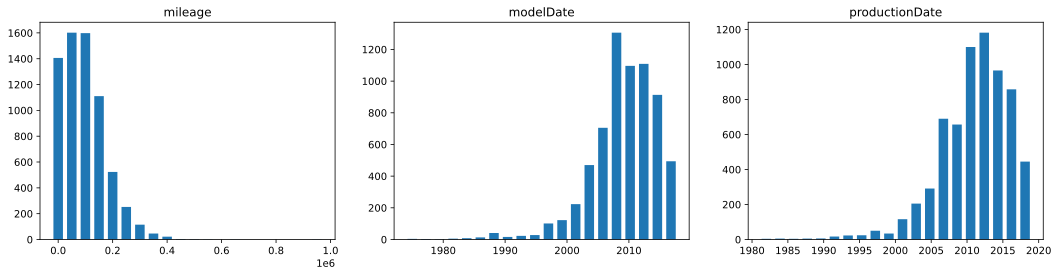

In [16]:
visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [17]:
#используем все текстовые признаки как категориальные без предобработки
#categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
#  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
#numerical_features = ['mileage', 'modelDate', 'productionDate']

In [18]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)
# (6682, 23) (1671, 23) (8353, 23)

(6682, 23) (1671, 23) (8353, 23)


In [19]:
print(data.info())
print(data.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

1. sell_id = 8353 = количество строк -> повторений нет
2. Владение = 2935 = 35% от общего числа -> слишком мало для автозаполнения, но можно вычислить с помощью productionDate

Группы признаков:
1. Категориальные:
    * bodyType, brand, color, fuelType, model_info, name (желательно сократить размерность), numberOfDoors, vehicleTransmission, Владельцы, ПТС, Привод, Руль
2. Числовые:
    * mileage, modelDate, productionDate (также сделать категориальным)
    * engineDisplacement, enginePower, Владение (представленны как текст)
    * price - целевой
3. Текстовые:
    * description
4. Изображение:
    * sell_id - файл доступен по адресу, основанному на sell_id

In [20]:
print(data['Владение'].nunique())
print(data['Владение'].unique())

180
['6 лет и 3 месяца' '6 лет и 6 месяцев' nan '3 года' '2 года и 2 месяца'
 '2 года и 4 месяца' '5 лет и 4 месяца' '8 лет' '3 года и 6 месяцев'
 '2 года и 7 месяцев' '2 года и 8 месяцев' '1 год и 3 месяца'
 '1 год и 2 месяца' '6 лет и 5 месяцев' '4 года и 10 месяцев'
 '3 года и 9 месяцев' '8 месяцев' '2 года и 5 месяцев' '2 года и 3 месяца'
 '4 года и 5 месяцев' '3 года и 7 месяцев' '3 года и 3 месяца'
 '3 года и 5 месяцев' '5 лет и 1 месяц' '4 года и 1 месяц'
 '10 лет и 3 месяца' '4 года и 2 месяца' '2 года и 6 месяцев'
 '5 лет и 2 месяца' '2 месяца' '6 лет и 8 месяцев' '1 год и 1 месяц'
 '1 год и 11 месяцев' '2 года и 9 месяцев' '18 лет и 9 месяцев'
 '1 год и 8 месяцев' '5 лет и 9 месяцев' '2 года' '4 года'
 '5 лет и 5 месяцев' '7 лет и 7 месяцев' '3 года и 2 месяца' '7 лет'
 '5 лет и 8 месяцев' '8 лет и 2 месяца' '6 лет' '9 месяцев'
 '2 года и 11 месяцев' '6 лет и 1 месяц' '3 года и 8 месяцев'
 '3 года и 1 месяц' '1 месяц' '1 год и 4 месяца' '2 года и 10 месяцев'
 '3 года и 11 мес

In [21]:
print(data['engineDisplacement'].nunique())
print(data['engineDisplacement'].unique())

48
['3.0 LTR' '2.5 LTR' '2.0 LTR' '3.5 LTR' '1.8 LTR' '2.2 LTR' '5.5 LTR'
 '4.8 LTR' '1.6 LTR' '4.7 LTR' '4.0 LTR' '1.5 LTR' '2.4 LTR' '1.4 LTR'
 '2.1 LTR' '5.2 LTR' '4.4 LTR' '2.8 LTR' '4.2 LTR' '3.2 LTR' '6.0 LTR'
 '3.7 LTR' '5.0 LTR' '1.2 LTR' '3.6 LTR' '2.3 LTR' '6.2 LTR' '1.7 LTR'
 '1.3 LTR' '5.4 LTR' '3.1 LTR' '2.6 LTR' '3.8 LTR' '4.1 LTR' '2.9 LTR'
 '6.6 LTR' '5.9 LTR' 'undefined LTR' '2.7 LTR' '0.7 LTR' '1.9 LTR'
 '4.3 LTR' '5.8 LTR' '4.9 LTR' '3.4 LTR' '6.3 LTR' '5.6 LTR' '4.6 LTR']


In [22]:
data_undef_LTR = data.query('engineDisplacement=="undefined LTR"')
data_undef_LTR
# так как fuelType = электро -> оставляем как есть

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
1005,хэтчбек 5 дв.,BMW,серебристый,.,undefined LTR,170 N12,электро,89942,2013,I3,...,1100166318,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,0.0
3967,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184 N12,электро,9000,2017,I3,...,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2719000.0
5396,хэтчбек 5 дв.,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",undefined LTR,170 N12,электро,39500,2017,I3,...,1098041130,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый,1,2299711.0
5397,хэтчбек 5 дв.,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,undefined LTR,170 N12,электро,28800,2017,I3,...,1100097316,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,2170000.0
7533,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170 N12,электро,35810,2013,I3,...,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1690000.0
7954,хэтчбек 5 дв.,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,undefined LTR,170 N12,электро,60000,2013,I3,...,1097395090,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,1,1790000.0


In [23]:
print(data['enginePower'].nunique())
print(data['enginePower'].unique())

154
['220 N12' '313 N12' '218 N12' '136 N12' '190 N12' '340 N12' '245 N12'
 '316 N12' '170 N12' '160 N12' '231 N12' '388 N12' '180 N12' '367 N12'
 '115 N12' '184 N12' '177 N12' '455 N12' '422 N12' '163 N12' '249 N12'
 '272 N12' '224 N12' '122 N12' '557 N12' '333 N12' '306 N12' '156 N12'
 '150 N12' '264 N12' '450 N12' '555 N12' '407 N12' '130 N12' '400 N12'
 '204 N12' '469 N12' '192 N12' '210 N12' '211 N12' '239 N12' '200 N12'
 '350 N12' '420 N12' '300 N12' '381 N12' '265 N12' '258 N12' '390 N12'
 '197 N12' '120 N12' '544 N12' '193 N12' '235 N12' '233 N12' '394 N12'
 '355 N12' '421 N12' '320 N12' '585 N12' '105 N12' '280 N12' '194 N12'
 '132 N12' '639 N12' '250 N12' '335 N12' '510 N12' '116 N12' '360 N12'
 '238 N12' '225 N12' '625 N12' '571 N12' '507 N12' '286 N12' '372 N12'
 '575 N12' '408 N12' '310 N12' '354 N12' '255 N12' '435 N12' '525 N12'
 '591 N12' '109 N12' '462 N12' '143 N12' '279 N12' '487 N12' '560 N12'
 '125 N12' '609 N12' '102 N12' '290 N12' '296 N12' '230 N12' '326 N12'
 '

In [24]:
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name',
                        'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

In [25]:
# Изучим на уникальность categorical_features
for column in data[categorical_features]:
    print(column+': '+str(data[column].unique()))

bodyType: ['универсал 5 дв.' 'купе' 'седан' 'внедорожник 5 дв.' 'родстер' 'лифтбек'
 'хэтчбек 3 дв.' 'хэтчбек 5 дв.' 'купе-хардтоп' 'внедорожник 3 дв.'
 'минивэн' 'кабриолет' 'пикап двойная кабина' 'внедорожник открытый'
 'компактвэн' 'седан 2 дв.' 'лимузин']
brand: ['MERCEDES' 'BMW' 'AUDI']
color: ['чёрный' 'белый' 'пурпурный' 'синий' 'коричневый' 'серый' 'зелёный'
 'серебристый' 'красный' 'оранжевый' 'голубой' 'фиолетовый' 'бежевый'
 'жёлтый' 'золотистый' 'розовый']
fuelType: ['бензин' 'дизель' 'гибрид' 'электро']
model_info: ['W124' '6ER' '3ER' '5ER' 'Q7' 'SL_KLASSE' 'A5' 'A4' 'GL_KLASSE' 'A6'
 '1ER' 'X5' 'X3' 'S_KLASSE' 'S_CLASS_MAYBACH' 'G_KLASSE' 'E_KLASSE' 'X7'
 'Q5' 'A3' 'B_KLASSE' '4' 'CLS_KLASSE_AMG' 'RS3' 'X6' 'C_KLASSE' 'X1' 'S8'
 'Q3' 'X6_M' '7ER' 'GLS_KLASSE' 'A7' 'GLC_KLASSE' 'TT' 'Q8' 'M3' 'M4'
 'C_KLASSE_AMG' 'X4' 'G_KLASSE_AMG' 'VITO' 'M_KLASSE' 'CLA_KLASSE' 'TTS'
 'GLK_KLASSE' 'SLK_KLASSE_AMG' 'CLS_KLASSE' 'R_KLASSE' 'S_KLASSE_AMG'
 'VIANO' 'GLE_KLASSE' 'S5' 'AMG_GT'

In [26]:
data[['name','bodyType', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info',
     'numberOfDoors', 'vehicleTransmission', 'Привод']].sample(5)
# содержит данные о: Привод, vehicleTransmission, engineDisplacement, enginePower (int), доп.инфо
# разный набор
# Привод: ['задний' 'полный = 4WD' 'передний']
# vehicleTransmission: ['автоматическая = AT' 'вариатор = CVT' 'роботизированная = AMT' 'механическая = MT']

,name,bodyType,engineDisplacement,enginePower,fuelType,model_info,numberOfDoors,vehicleTransmission,Привод
7399,28i xDrive 2.0 AT (245 л.с.) 4WD,внедорожник 5 дв.,2.0 LTR,245 N12,бензин,X3,5,автоматическая,полный
4273,40e 2.0hyb AT (245 л.с.) 4WD,внедорожник 5 дв.,2.0 LTR,245 N12,гибрид,X5,5,автоматическая,полный
3362,63 AMG Long 5.5 AT (585 л.с.) 4WD,седан,5.5 LTR,585 N12,бензин,S_KLASSE_AMG,4,автоматическая,полный
2794,3.0d AMT (245 л.с.) 4WD,седан,3.0 LTR,245 N12,дизель,A6,4,роботизированная,полный
5378,525d xDrive 2.0d AT (218 л.с.) 4WD,седан,2.0 LTR,218 N12,дизель,5ER,4,автоматическая,полный


In [27]:
# вытащим из наименования полезную информацию
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.name)

tokenize.word_index

{'л': 1,
 'с': 2,
 'at': 3,
 '4wd': 4,
 '2': 5,
 '0': 6,
 '3': 7,
 '0d': 8,
 '4': 9,
 '5': 10,
 'amt': 11,
 '1': 12,
 'xdrive': 13,
 '184': 14,
 '249': 15,
 '8': 16,
 '350': 17,
 '6': 18,
 '200': 19,
 '190': 20,
 'cvt': 21,
 '180': 22,
 'amg': 23,
 '245': 24,
 '306': 25,
 '211': 26,
 'long': 27,
 '500': 28,
 'd': 29,
 '150': 30,
 '170': 31,
 '63': 32,
 '250': 33,
 '30d': 34,
 '1d': 35,
 '218': 36,
 '156': 37,
 'cdi': 38,
 '320i': 39,
 '272': 40,
 '136': 41,
 'mt': 42,
 '7': 43,
 '231': 44,
 '204': 45,
 '300': 46,
 '20d': 47,
 '400': 48,
 '35i': 49,
 '333': 50,
 '258': 51,
 '520d': 52,
 '320': 53,
 '220': 54,
 'bluetec': 55,
 '450': 56,
 '177': 57,
 '520i': 58,
 '367': 59,
 '530d': 60,
 '20i': 61,
 '122': 62,
 '585': 63,
 '116i': 64,
 '407': 65,
 '225': 66,
 '320d': 67,
 '224': 68,
 '160': 69,
 '388': 70,
 '528i': 71,
 '340': 72,
 '318i': 73,
 '235': 74,
 '40d': 75,
 '192': 76,
 's': 77,
 '313': 78,
 '115': 79,
 '525i': 80,
 '163': 81,
 '435': 82,
 '28i': 83,
 '9d': 84,
 '455': 85,
 '0i

- xdrive = полный привод; sdrive - задний привод: данная информация уже имеется в характеристиках
- полезные слова: 
    * amg
    * long
    * длинный
    * экстра длинный
    * competition
    * компактный
    * brabus
- остальное в поле name не является важной информацией - избавимся от этого поля

In [28]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    # df_output['description_len'] = df_output['description'].dropna().apply(lambda x: len(x))
    df_output.drop(['description','sell_id','vehicleConfiguration'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    # for column in numerical_features:
    #    df_output[column].fillna(df_output[column].median(), inplace=True)
    
    # тут ваш код по обработке NAN
    
    # engineDisplacement, enginePower, Владение (представленны как текст)
    df_output['Владение'] = pd.to_datetime(datetime.today()).year - df_output['productionDate']-1
    df_output['enginePower'] = df_output['enginePower'].dropna().apply(lambda x: np.nan if len(x[:-4])==0 else float(x[:-4]))
    df_output['engineDisplacement'] = df_output['engineDisplacement'].dropna().apply(lambda x: 0.0 if x=='undefined LTR' else float(x[:-4]))
    
    numerical_features = ['mileage', 'modelDate', 'productionDate', 'engineDisplacement', 'enginePower', 'Владение']
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    
    # Владельцы - почистим поле
    df_output['Владельцы'] = df_output['Владельцы'].dropna().apply(lambda x: np.nan if len(x)==0 else str(x[0]))
    
    # name - понижение размерности
    # df_output['name'] = df_output['name'].dropna().apply(lambda x: str(x[:-4]) if str(x[len(x)-3:])=='4WD' else x)
    # df_output['name'] = df_output['name'].dropna().apply(lambda x: np.nan if len(x.split(' '))==4 else (str(x.split(' ')[:-4])[2:-2] if len(x.split(' '))==5 else str(x.split(' ')[:-4])[2:-2].replace("', '", ' ')))
    
    # новые поля сделаем бинарными
    df_output['AMG'] = df_output['name'].dropna().apply(lambda x: 1 if x.find('AMG') != -1 else 0)
    df_output['Brabus'] = df_output['name'].dropna().apply(lambda x: 1 if x.find('Brabus') != -1 else 0)
    df_output['Competition'] = df_output['name'].dropna().apply(lambda x: 1 if x.find('Competition') != -1 else 0)
    df_output['компактный'] = df_output['name'].dropna().apply(lambda x: 1 if x.find('компактный') != -1 else 0)
    df_output['экстра длинный'] = df_output['name'].dropna().apply(lambda x: 1 if x.find('экстра длинный') != -1 else 0)
    df_output['длинный'] = df_output['name'].dropna().apply(lambda x: 1 if x.find('длинный') != -1 else (1 if x.find('long') != -1 else 0))
    
    binar_features = ['AMG', 'Brabus', 'Competition', 'компактный', 'длинный', 'экстра длинный']
    
    # остальное в поле name не является важной информацией - избавимся от этого поля
    # 'modelDate', 'productionDate' - также сделаем категориальными
    df_output['modelDate_cat'] = df_output['modelDate']
    df_output['productionDate_cat'] = df_output['productionDate']
    
    categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
                            'modelDate_cat', 'productionDate_cat','numberOfDoors',
                            'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']
    
    # modelDateNorm = np.log(2020 - data['modelDate'])
    # все распределения с тяжелым правым хвостом можно пробовать подвергнуть такому преобразованию
    # mileage, enginePower, Владение - имеют правый хвост
    # for column in df_output[['mileage', 'enginePower', 'Владение']]:
    #     df_output[column] = df_output[column].dropna().apply(lambda x: np.log(x + 1))
    
    # Нормализация данных
    scaler = MinMaxScaler()
    
    train = df_output.query('sample == 1')
    for column in numerical_features:
        train[column] = scaler.fit_transform(train[[column]])[:,0]
    
    test = df_output.query('sample == 0')
    for column in numerical_features:
        test[column] = scaler.fit_transform(test[[column]])[:,0]
        
    df_output = test.append(train, sort=False).reset_index(drop=True) # объединяем
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    df_output.drop(['name'], axis = 1, inplace=True)
    
    return df_output

In [29]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,AMG,Brabus,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
3640,0.303030,0.221631,0.222999,0.750000,0.684211,0.315789,1,630000.0,0,0,...,1,0,0,0,1,0,0,1,1,0
6421,0.303030,0.132979,0.157594,0.772727,0.789474,0.210526,1,680000.0,0,0,...,0,1,0,0,1,1,0,0,1,0
7645,0.272727,0.150709,0.094999,0.727273,0.710526,0.289474,1,599000.0,0,0,...,0,1,0,0,1,0,1,0,1,0
7222,0.303030,0.301418,0.034999,0.909091,0.894737,0.105263,1,2150000.0,0,0,...,0,1,0,0,1,0,0,1,1,0
4604,0.454545,0.324468,0.129999,0.772727,0.789474,0.210526,1,1290000.0,0,0,...,0,1,0,0,1,0,0,1,1,0
5140,0.196970,0.132979,0.011007,0.977273,0.973684,0.026316,1,1898000.0,0,0,...,1,0,0,0,1,0,1,0,1,0
728,0.272727,0.098497,0.158999,0.750000,0.763158,0.236842,0,0.0,0,0,...,0,0,1,0,1,0,1,0,1,0
7029,0.378788,0.253546,0.095999,0.613636,0.631579,0.368421,1,675000.0,0,0,...,1,0,0,0,1,1,0,0,1,0
1997,0.454545,0.409574,0.228204,0.727273,0.710526,0.289474,1,970000.0,0,0,...,0,0,1,0,1,0,0,1,1,0
3433,0.303030,0.241135,0.159999,0.818182,0.789474,0.210526,1,890000.0,0,0,...,0,0,1,0,1,0,0,1,1,0


In [30]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 277 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(7), uint8(263)
memory usage: 3.0 MB


In [31]:
binar_features = ['AMG', 'Brabus', 'Competition', 'компактный', 'длинный', 'экстра длинный']

for column in df_preproc[binar_features]:
    print(column+': '+str(df_preproc[column].unique()))

AMG: [0 1]
Brabus: [0 1]
Competition: [0 1]
компактный: [0 1]
длинный: [0 1]
экстра длинный: [0 1]


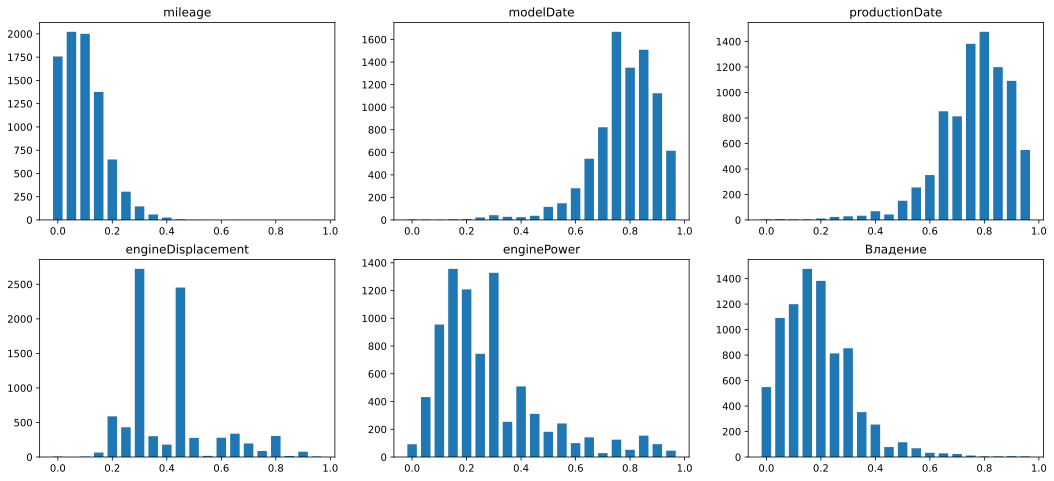

In [32]:
visualize_distributions({
    'mileage': df_preproc['mileage'].dropna(),
    'modelDate': df_preproc['modelDate'].dropna(),
    'productionDate': df_preproc['productionDate'].dropna(),
    'engineDisplacement': df_preproc['engineDisplacement'].dropna(),
    'enginePower': df_preproc['enginePower'].dropna(),
    'Владение': df_preproc['Владение'].dropna(),
    # 'description_len': df_preproc['description_len'].dropna()
})
# mileage, enginePower, Владение - имеет правый хвост

## Split data

In [33]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 276 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(6), uint8(263)
memory usage: 611.9 KB


# Model 2: CatBoostRegressor

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [36]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.11,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
# TEST mape: 13.23%
# TEST mape: 12.33%
# TEST mape: 12.74% с длиной описания и логарифмированием

TEST mape: 12.42%


### Submission

In [38]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [39]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,AMG,Brabus,Competition,компактный,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.909091,0.831560,0.149999,0.750000,0.763158,0.236842,0,0,0,0,...,1,0,0,0,1,1,0,0,1,0
8037,0.303030,0.301418,0.020941,0.931818,0.947368,0.052632,0,0,0,0,...,1,0,0,0,1,0,0,1,1,0
4681,0.469697,0.319149,0.133896,0.659091,0.631579,0.368421,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0
6014,0.272727,0.193262,0.330000,0.704545,0.657895,0.342105,0,0,0,0,...,0,0,1,0,1,1,0,0,1,0
3649,0.454545,0.421986,0.125999,0.818182,0.815789,0.184211,0,0,0,0,...,1,0,0,0,1,0,0,1,1,0


## Simple Dense NN

In [40]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               141312    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 272,897
Trainable params: 272,897
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [43]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [44]:
clear_session()

In [45]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=100,
                   )

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

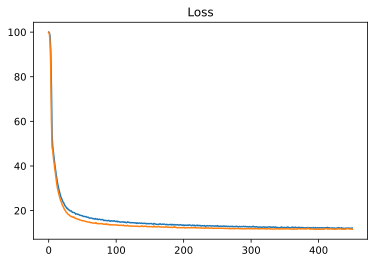

In [46]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [47]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [48]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")
# TEST mape: 14.01%
# TEST mape: 11.81%
# TEST mape: 12.25% с честной нормализацией и логарифмированием
# TEST mape: 11.95% без логарифмирования
# TEST mape: 11.87% с честной нормализацией по отдельности без логарифмирования
# TEST mape: 12.11% с длиной описания и логарифмированием
# TEST mape: 12.29% с честной нормализацией по отдельности и логарифмированием без описания
# TEST mape: 11.78% с честной нормализацией по отдельности без логарифмирования

TEST mape: 11.66%


In [49]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [50]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [51]:
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,...,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,...,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,...,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0


In [52]:
data['description'][1]

'Продаю любимейшую тачилу.. Обвес и тюнинг Hamman. Потому что совсем на ней не езжу, а она должна резвиться и служить. Авто с хорошей кармой. С хорошим звуком и вообще приятнейшая. \n\nИз-за частых командировок машиной не пользовалась, отсюда и такой маленький пробег. Были 2 мелких аварии (не увидела столбик во дворе и ещё раз не увидела, но сделала ремонт и все части поврежденные отремонтировала).\n\nНа фото летняя резина на родных дисках, а у меня есть ещё зимняя резина на супер красивых дисках! Отдам вместе с машиной бонусом. Если купит девушка - то с меня патчи и блеск для губ ❤️'

In [53]:
data['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', nan],
      dtype=object)

In [54]:
data_1 = data.query('Владельцы=="1\xa0владелец"')
for d in data_1['description'][:4]:
    print(d)
# абсолютно разные варианты описаний, 
# скорее всего при 1 владельце - больше нестандартных описаний

Продаю любимейшую тачилу.. Обвес и тюнинг Hamman. Потому что совсем на ней не езжу, а она должна резвиться и служить. Авто с хорошей кармой. С хорошим звуком и вообще приятнейшая. 

Из-за частых командировок машиной не пользовалась, отсюда и такой маленький пробег. Были 2 мелких аварии (не увидела столбик во дворе и ещё раз не увидела, но сделала ремонт и все части поврежденные отремонтировала).

На фото летняя резина на родных дисках, а у меня есть ещё зимняя резина на супер красивых дисках! Отдам вместе с машиной бонусом. Если купит девушка - то с меня патчи и блеск для губ ❤️
Немка! с бесключивым доступом и камерой заднего вида.
Автомобиль в пленке Santek - зоны риска, морда, на лобовом стекле так же защитная пленка, трехслойная керамика - поверх пленки, диски от 530 - 19 радиус - разноширокие - 150 тысяч рублей, приборная панель, NBT EVO professional, большая шайба, мозги и усилитель от Harman/Kardon - 100 тысяч рублей (заводское лежит все в гараже, меняется 1 час в мастерской), ма

In [55]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [56]:
import re
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords, words
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [57]:
# data = test.append(train, sort=False)
# train.shape, test.shape, data.shape
# (6682, 23) (1671, 23) (8353, 23)
# train['sample'] = 1
data.query('sample==1').description.head()

1671    Авто на бодром ходу.  Все работает отлично.  П...
1672    Продажа от собственника, второй владелец, ПТС ...
1673    Внимание! Только для клиентов AVILON Автомобил...
1674    В комплекте зимние колёса. 27.07.2020 Замена п...
1675    Отличный авто, 2011 года выпуска, кроме передн...
Name: description, dtype: object

In [58]:
data.query('sample==0').description.head()

0    Всем привет!\n\nПродам эксклюзивный проект 124...
1    Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2    Машина тут продаётся не в первый раз, НО! Толь...
3    Автомобиль в отличном состоянии, весь в родной...
4    Немка! с бесключивым доступом и камерой заднег...
Name: description, dtype: object

In [59]:
# Let's group descriptions by genre 
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

data_combined = pd.DataFrame(data.groupby(['sample'])['description'].apply(combine_text))

In [60]:
data_combined

,description
sample,
0,Всем привет!\n\nПродам эксклюзивный проект 124...
1,Авто на бодром ходу. Все работает отлично. П...


In [61]:
combined_train = data_combined.query('sample==1').description
combined_train

sample
1    Авто на бодром ходу.  Все работает отлично.  П...
Name: description, dtype: object

In [62]:
def clean_text_small(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    ## letters = re.findall('[a-zA-Z\s]', text)# rid on non-Latin characters
    ## text = ''.join(letters)
    text = re.sub('\[*?\]', '', text) # brackets
    # text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #punctuation
    text = re.sub('\w*\d\w*', '', text) # numbers
    '''Get rid of some additional punctuation and non-sensical text.'''
    text = re.sub('[‘’“”…]', '', text) # upper punctuation
    text = re.sub('\n', '! ', text) # any \n
    # text = re.sub('["#$%&\'()*+-/:;<=>?@[\\]^_`{|}~]', '', text)
    
    return text

clean_small = lambda x: clean_text_small(x)

In [63]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
# data_clean_small = data.description.copy()
data_clean_small = combined_train.copy()
data_clean_small = data_clean_small.apply(clean_small)
data_clean_small

sample
1    авто на бодром ходу.  все работает отлично.  п...
Name: description, dtype: object

In [65]:
data_clean_sent = data_clean_small.apply(lambda x: nltk.sent_tokenize(x))
data_clean_sent

sample
1    [авто на бодром ходу., все работает отлично., ...
Name: description, dtype: object

In [66]:
print(stopwords.words('russian'))
# "не" ?????

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [67]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
words = set(nltk.corpus.words.words())

In [68]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    ## letters = re.findall('[а-яА-Я\s]', text)# rid on non-Russian characters
    ## text = ''.join(letters)
    text = re.sub('\[.*?\]', '', text) # brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #punctuation
    text = re.sub('\w*\d\w*', '', text) # numbers
    '''Get rid of some additional punctuation and non-sensical text.'''
    text = re.sub('[‘’“”…]', '', text) # upper punctuation
    text = re.sub('\n', ' ', text) # any \n
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)  
    
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('russian')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    # return " ".join(w for w in lemma_words if w.lower() in words)
    return " ".join(w for w in lemma_words)

clean = lambda x: clean_text(x)

In [69]:
# data_clean = data.description.copy()
data_clean = combined_train.copy()
data_clean = data_clean.apply(clean)
data_clean

sample
1    авто бодром ходу работает отлично электрикеход...
Name: description, dtype: object

In [70]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [71]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
cv = CountVectorizer()
data_cv = cv.fit_transform(data_clean)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,aa,aac,ab,abblendend,abc,abcв,ablagenpaket,abt,abtodom,acc,...,ящике,ящики,ящиков,ящиком,ящичком,ёмкости,ёмкость,ёмкостью,ёэфшт,ґхъяырэъш
sample,,,,,,,,,,,,,,,,,,,,,
1,1,4,145,1,5,1,1,5,362,13,...,1,4,1,1,1,16,5,2,1,2


In [72]:
# Most common Words
data_t = data_dtm.T

# Find the top 100 words
top_dict = {}
top_list = []
for c in data_t.columns:
    top = data_t[c].sort_values(ascending=False).head(100)
    top_dict[c]= list(zip(top.index, top.values))
    top_list.append(top.index)
top_list_n = []
for x in top_list:
    for y in x:
        top_list_n.append(y)
len(top_list_n)

100

In [73]:
# Less common Words
les_dict = {}
les_list = []
for c in data_t.columns:
    less = data_t[c].sort_values(ascending=True).head(100)
    les_dict[c]= list(zip(less.index, less.values))
    les_list.append(less.index)
les_list_n = []
for x in les_list:
    for y in x:
        les_list_n.append(y)
len(les_list_n)

100

In [74]:
data_clean_reduced = data_clean.copy()

In [75]:
def reduced_text(text):
    for w in top_list_n:
        text = re.sub(w, '', text)
    for s in les_list_n:
        text = re.sub(s, '', text)
        
    return text

In [76]:
data_clean_reduced = data_clean_reduced.apply(reduced_text)

In [77]:
data_word_sent = data_clean_reduced.append(data_clean_sent).reset_index(drop=True) # объединяем
data_word_sent

0     бодром ходу работает отлично электрикеходовой...
1    [авто на бодром ходу., все работает отлично., ...
Name: description, dtype: object

In [78]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(data.description)
tokenize.fit_on_texts(data_word_sent)

CPU times: user 777 ms, sys: 19.1 ms, total: 797 ms
Wall time: 795 ms


### Tokenizer

In [79]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [80]:
# Благодаря получившемуся словарю мы сможем произвести дальнейшую векторизацию нашего текста. 
# %%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)


In [81]:
# вот так теперь выглядит наш текст
print(text_train.iloc[151])
print(text_train_sequences[151])

Продажа от собственника! Продаётся надёжный, роскошный, брутальный красавец - флагманский Mercedes-Benz S-Klass ll (W126) 380-SE, 1985 года выпуска. Цвет - чёрный графит. Салон - светло-бежевый велюр. Гаражного хранения. Полностью весь в оригинале! Пробег - оригинальный! Никаких вмешательств! Своевременное обслуживание. Из Германии. По РФ пробега практически нет, исключительно в летнюю, сухую погоду. Фактически в одних руках (в одной семье). ПТС-оригинал, два комплекта ключей. В ДТП не участвовал. Богатая и самая полная комплектация. Красивый, мощный, ухоженный, солидный автомобиль в отличном внешнем и техническом состоянии. Настоящая немецкая раритетная классика! Для настоящих ценителей! Просто - произведение искусства! Создаётся впечатление, что время его не коснулось! Состояние свежего, не уставшего автомобиля. Аккуратная, бережная, безаварийная эксплуатация. Зимой не эксплуатировался вообще!! В «покатушках» не участвовал! Всё это видно. В салоне не курили! Полнейший, стопроцентный 

In [82]:
print(len(tokenize.word_index)+1)
print(MAX_SEQUENCE_LENGTH)

80898
256


In [83]:
clear_session()

### RNN NLP

In [84]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [85]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [86]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [87]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     20709888    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [88]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [89]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [90]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 7s 590ms/step - loss: 99.9840 - MAPE: 99.9840 - val_loss: 99.8119 - val_MAPE: 99.8119
Epoch 2/500
12/12 [==============================] - 7s 567ms/step - loss: 98.3008 - MAPE: 98.3008 - val_loss: 92.2049 - val_MAPE: 92.2049
Epoch 3/500
12/12 [==============================] - 6s 529ms/step - loss: 75.3756 - MAPE: 75.3756 - val_loss: 48.8750 - val_MAPE: 48.8750
Epoch 4/500
12/12 [==============================] - 6s 537ms/step - loss: 51.5036 - MAPE: 51.5036 - val_loss: 44.5587 - val_MAPE: 44.5587
Epoch 5/500
12/12 [==============================] - 6s 524ms/step - loss: 43.7159 - MAPE: 43.7159 - val_loss: 39.2348 - val_MAPE: 39.2348
Epoch 6/500
12/12 [==============================] - 6s 535ms/step - loss: 37.6164 - MAPE: 37.6164 - val_loss: 33.4382 - val_MAPE: 33.4382
Epoch 7/500
12/12 [==============================] - 7s 558ms/step - loss: 32.8184 - MAPE: 32.8184 - val_loss: 29.4201 - val_MAPE: 29.4201
Epoch 8/500
12/12 [========

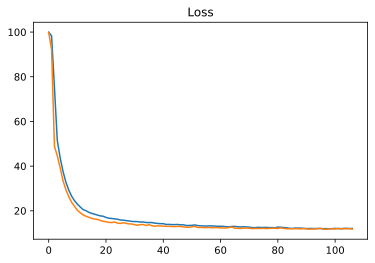

In [91]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [92]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [93]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")
# TEST mape: 14.41%
# TEST mape: 11.96% против 11.87% - очистка и лемматизация слов
# TEST mape: 11.78% - плюс токенизация предложений - никакого влияния - не ухудшило
# TEST mape: 11.74% - все то же, но честно + убрала 100 top и 100 less слов

TEST mape: 11.82%


In [94]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

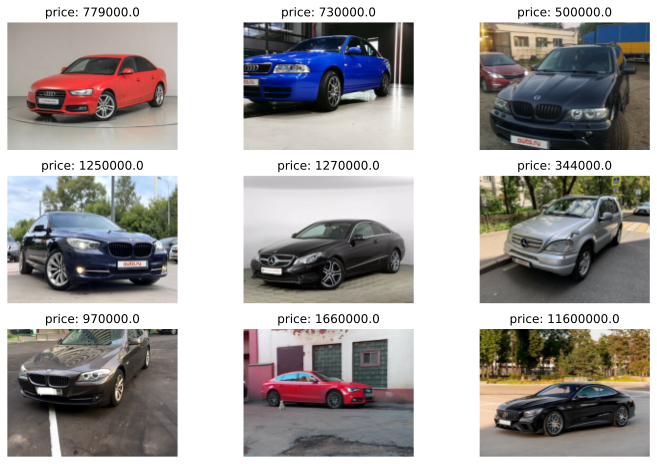

In [95]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [96]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

In [97]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

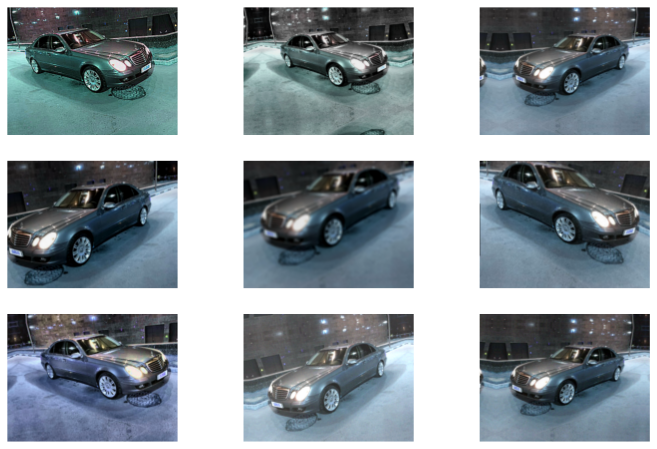

In [98]:
#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.3),
    OneOf([
        MotionBlur(p=0.6),
        MedianBlur(blur_limit=3, p=0.3),
        Blur(blur_limit=5, p=0.3),
    ], p=0.1),
##    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    ShiftScaleRotate(shift_limit=0.07, scale_limit=0.2, rotate_limit=10, p=1),
    OneOf([
        OpticalDistortion(p=0.1),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.05),
    ], p=0.1),
    OneOf([
        CLAHE(clip_limit=5),
        IAASharpen(p=0.3),
        IAAEmboss(p=0.1),
        RandomBrightnessContrast(p=0.5),
    ], p=0.5),
    HueSaturationValue(p=0.5),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[3])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [99]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [100]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(data.description)
tokenize.fit_on_texts(data_word_sent)

In [101]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [102]:
clear_session()

In [103]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

# base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

43941888/43941136 [==============================] - 0s 0us/step


In [104]:
efficientnet_model.trainable = False

In [105]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [106]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.5),
    L.Dense(64),
    L.Dropout(0.25),
    ])

In [107]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [108]:
print(len(model.layers))
print(len(model.trainable_variables))

401
17


In [109]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [110]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [111]:
history = model.fit(train_dataset.batch(10),
                    epochs=5,
                    validation_data = test_dataset.batch(10),
                    callbacks=callbacks_list
                   )
# epochs = 100

Epoch 1/5
568/568 [==============================] - 223s 393ms/step - loss: 33.4993 - MAPE: 33.4993 - val_loss: 18.8491 - val_MAPE: 18.8491
Epoch 2/5
568/568 [==============================] - 220s 387ms/step - loss: 18.9280 - MAPE: 18.9280 - val_loss: 16.8519 - val_MAPE: 16.8519
Epoch 3/5
568/568 [==============================] - 221s 389ms/step - loss: 16.7957 - MAPE: 16.7957 - val_loss: 14.3282 - val_MAPE: 14.3282
Epoch 4/5
568/568 [==============================] - 222s 391ms/step - loss: 15.7105 - MAPE: 15.7105 - val_loss: 14.5209 - val_MAPE: 14.5209
Epoch 5/5
568/568 [==============================] - 222s 390ms/step - loss: 15.0119 - MAPE: 15.0119 - val_loss: 12.8903 - val_MAPE: 12.8903


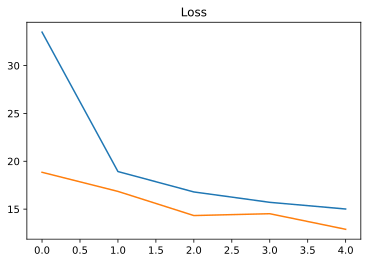

In [112]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [113]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final_1.hdf5')

In [114]:
test_predict_nn3 = model.predict(test_dataset.batch(10))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.89%


In [115]:
efficientnet_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(efficientnet_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False

len(efficientnet_model.trainable_variables)

171

In [116]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [117]:
history = model.fit(train_dataset.batch(10),
                    epochs=10,
                    validation_data = test_dataset.batch(10),
                    callbacks=callbacks_list
                   )

Epoch 1/10
568/568 [==============================] - 236s 416ms/step - loss: 14.0360 - MAPE: 14.0360 - val_loss: 15.9956 - val_MAPE: 15.9956
Epoch 2/10
568/568 [==============================] - 239s 421ms/step - loss: 13.6079 - MAPE: 13.6079 - val_loss: 12.1019 - val_MAPE: 12.1019
Epoch 3/10
568/568 [==============================] - 235s 415ms/step - loss: 13.6239 - MAPE: 13.6239 - val_loss: 12.1413 - val_MAPE: 12.1413
Epoch 4/10
568/568 [==============================] - 238s 419ms/step - loss: 13.4024 - MAPE: 13.4024 - val_loss: 12.0902 - val_MAPE: 12.0902
Epoch 5/10
568/568 [==============================] - 237s 417ms/step - loss: 13.2878 - MAPE: 13.2878 - val_loss: 12.1465 - val_MAPE: 12.1465
Epoch 6/10
568/568 [==============================] - 237s 417ms/step - loss: 13.0268 - MAPE: 13.0268 - val_loss: 11.7900 - val_MAPE: 11.7900
Epoch 7/10
568/568 [==============================] - 237s 417ms/step - loss: 13.1139 - MAPE: 13.1139 - val_loss: 12.9233 - val_MAPE: 12.9233
Epoch 

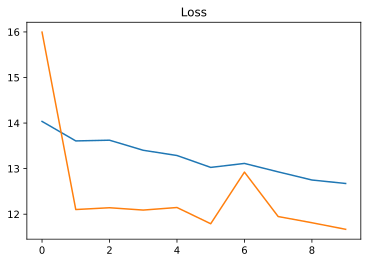

In [118]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [119]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final_2.hdf5')

In [120]:
test_predict_nn3 = model.predict(test_dataset.batch(10))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.67%


In [121]:
efficientnet_model.trainable = True

In [122]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [123]:
history = model.fit(train_dataset.batch(10),
                    epochs=10,
                    validation_data = test_dataset.batch(10),
                    callbacks=callbacks_list
                   )

Epoch 1/10
568/568 [==============================] - 279s 492ms/step - loss: 12.5415 - MAPE: 12.5415 - val_loss: 11.6011 - val_MAPE: 11.6011
Epoch 2/10
568/568 [==============================] - 271s 477ms/step - loss: 12.2940 - MAPE: 12.2940 - val_loss: 11.6142 - val_MAPE: 11.6142
Epoch 3/10
568/568 [==============================] - 268s 472ms/step - loss: 12.4690 - MAPE: 12.4690 - val_loss: 11.5967 - val_MAPE: 11.5967
Epoch 4/10
568/568 [==============================] - 266s 469ms/step - loss: 12.4559 - MAPE: 12.4559 - val_loss: 11.5770 - val_MAPE: 11.5770
Epoch 5/10
568/568 [==============================] - 268s 472ms/step - loss: 12.2948 - MAPE: 12.2948 - val_loss: 11.5327 - val_MAPE: 11.5327
Epoch 6/10
568/568 [==============================] - 269s 473ms/step - loss: 12.5509 - MAPE: 12.5509 - val_loss: 11.5547 - val_MAPE: 11.5547
Epoch 7/10
568/568 [==============================] - 272s 479ms/step - loss: 12.3173 - MAPE: 12.3173 - val_loss: 11.5540 - val_MAPE: 11.5540
Epoch 

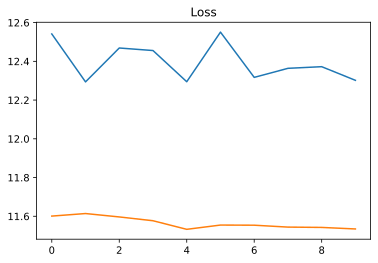

In [124]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [125]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final_3.hdf5')

In [126]:
test_predict_nn3 = model.predict(test_dataset.batch(10))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.53%


In [127]:
sub_predict_nn3 = model.predict(sub_dataset.batch(10))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [128]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.97%


In [129]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [130]:
# MLP
# model_mlp = Sequential()
# model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
# model_mlp.add(L.Dropout(0.5))
# model_mlp.add(L.Dense(256, activation="relu"))
# model_mlp.add(L.Dropout(0.5))

In [131]:
# FEATURE Input
# Iput
# productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
# emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
#f_productiondate = L.Flatten()(emb_productiondate)

In [132]:
# combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
# head = L.Dense(64, activation="relu")(combinedInput)
# head = L.Dense(1, activation="linear")(head)

# model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [133]:
# model.summary()

In [134]:
# optimizer = tf.keras.optimizers.Adam(0.01)
# model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [135]:
# history = model.fit([X_train, X_train.productionDate.values], y_train,
#                     batch_size=512,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=([X_test, X_test.productionDate.values], y_test),
#                     callbacks=callbacks_list
#                    )

In [136]:
# model.load_weights('../working/best_model.hdf5')
# test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
# print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [137]:
# 